# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 08.12.2025

Мягкий дедлайн: 19.12.2025 23:59 MSK

Жёсткий дедлайн: 22.12.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb
* Модуль boosting.py

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, поэтому придется научиться им пользоваться

In [171]:
from warnings import filterwarnings

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

Мы будем работать с датасетом по предсказанию гендера. Никакие фичи мы придумывать не будем, но если вам интересно, в датасете имеется:

- region — регион, в котором проводили опрос
- age — возраст опрошенного
- year — год опроса
- race — этническая принадлежность
- sch — количество классов образования
- empstat — статус трудоустройства
- occ — код профессии
- ind — код индустрии, в которой человек работает
- annhrs — число часов работы в год
- hrwage — почасовая оплата
- icwage — суммарная оплата в год
- occupation — должность

Целевая метрика ROC-AUC, потому что мы непритязательны и это не фокус этой домашки



In [172]:
df = pd.read_parquet("boosting_dataset.pq")

X = df.drop("sex", axis=1)
y = df["sex"]

Пока что мы временно выкинем колонку с должностью, но мы к ней обязательно вернемся

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop("occupation", axis=1).values, y.values, test_size=0.2, random_state=1337
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1337
)

X_train.shape, X_valid.shape, X_test.shape

((8000, 11), (1000, 11), (1000, 11))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='#b962c4'>**вопросы**</font> должен быть <font color='#b962c4'>**ответ**</font>. В заданиях, где нужно делать параметры, часто есть референсы из других библиотек. На случай, если объяснение из ноутбука непонятно, советуем обратиться к соответствующей документации и пощупать, как это делается там

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Существующие параметры:
- `base_model_class` — класс базовой модели нашего бустинга
- `base_model_params` — словарь с гиперпараметрами для базовой модели
- `n_estimators` — какое количество базовых моделей нужно обучить
- `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$
- `random_state`— в роли рандом стейта
- `verbose` — для тех, кому не нравится загадочность, можно включить и увидеть, сколько еще ждать конца обучения

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

1. Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`).
2. После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах).
3. После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

#### `partial_fit`

В `partial_fit` передаются данные `X: np.ndarray, y: np.ndarray` для одного шага бустинга: обучаем следующую базовую модель на антиградиенте и обновляем ансамбль.

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

In [174]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
%autoreload 2

from boosting import Boosting

### Проверка кода

In [176]:
boosting = Boosting(
    verbose=True,
    random_state=69, # не забывайте фиксировать, пожалуйста
    bootstrap_type=None
)

boosting.fit(X_train, y_train)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2), "prediction shapes are incorrect"
assert np.array_equal(boosting.history["train_loss"], np.sort(boosting.history["train_loss"])[::-1]), "train loss is not decreasing"

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

# здесь и далее работаем с метрикой ROC-AUC
print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Train ROC-AUC 1.0000
Valid ROC-AUC 0.7199
Test ROC-AUC 0.7506


Хорошим знаком будет ROC-AUC в районе 0.7, в зависимости от сида. Дефолтные параметры специально такие, чтобы прогнать модель быстро, поэтому не отчаивайтесь

---

## Задание 2. Имплементация гиперпараметров (3.5 балла | 3 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации.

В этом пункте мы будем делать кучу самых разных гиперпараметров, каждый из них прекрасен по-своему, но полноценно их эффект получится ощутить лишь на этапе их перебора (кроме, пожалуй, `rsm`), поэтому делать третью часть до второй не рекомендуется

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону. Для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**гарантии, что дефолтные параметры подойдут, нет**</font>. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотреть именно на них

### 2.1. Борьба с переобучением (1 балл)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации прямо во время обучения. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете в дальнейшем делать для трейна, нужно будет повторить на валидации

Добавьте в вашу модель:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `eval_metric: str | None = None` — метрика, на которую смотрим, чтобы остановить обучение, может быть ключом из `model.history`
- `plot_history(self, keys: str | Iterable[str])` — метод, который строит график изменения метрики по ключам из `model.history`

И конкретно в метод `model.fit`:
- `eval_set: Tuple[np.ndarray] | None = None` — валидационная выборка `X_valid: np.ndarray, y_valid: np.ndarray`, на которой будем проверять переобучение
- `use_best_model: bool = False` — использовать лучшую модель, или нет. Если да, то отрезаем гаммы и модели вплоть до той, на которой остановились, минус `early_stopping_rounds`, т.е самой лучшей, после которой качество только падает

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td colspan="3" align="center"><code>early_stopping_rounds</code>, <code>eval_set</code></td>
</tr>
</table>

</div>

Продемонстрируйте, что все работает

  0%|          | 0/100 [00:00<?, ?it/s]

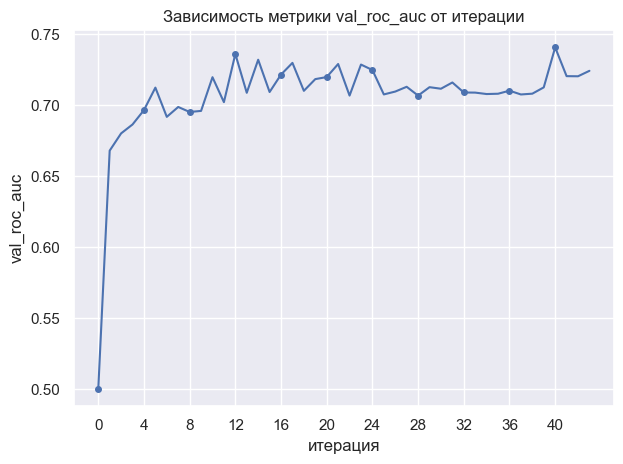

In [104]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_loss',
    n_estimators=100,
    bootstrap_type=None
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', t=4)

### Бонус. Бустинг линейных моделей (0.5 балла)

<font color='#b962c4'>**Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='#b962c4'>**Ответ:** Модель останется линейной, это не имеет смысла. Надо добавить нелинейный элемент, чтобы получить хорошую модель

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='#2f82d4'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>XGBClassifier(booster="gblinear")</code></td>
<td align="center">-</td>
<td align="center">-</td>
</tr>
</table>

</div>

In [105]:
import time
import xgboost as xgb
from sklearn.metrics import log_loss
import numpy as np


y_train_transformed = np.where(y_train == -1, 0, y_train)
y_valid_transformed = np.where(y_valid == -1, 0, y_valid)

xgb_model = xgb.XGBClassifier(
    booster="gblinear",
    n_estimators=100,
    objective='binary:logistic',
    random_state=69,
    eval_metric="logloss",  
    verbosity=1
)

eval_set = [(X_train, y_train_transformed), (X_valid, y_valid_transformed)]

start_time = time.time()

xgb_model.fit(
    X_train, 
    y_train_transformed,
    eval_set=eval_set,
    verbose=False
)

xgd_time = time.time() - start_time

# Вытаскиваем историю функции потерь
history = xgb_model.evals_result()
xgd_loss_train = history['validation_0']['logloss']
xgd_loss_val = history['validation_1']['logloss']

Теперь возьмите `sklearn.linear_model.SGDClassifier` и обучите на тех же данных. Не забудьте понять, как вытащить оттуда историю функции потерь

In [106]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

sgd = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    warm_start=True,
    random_state=69
)

sgd_loss_train = []
sgd_loss_val = []

start_time = time.time()

# Делаем батч
batch_size = 32
n_batches = len(X_train_scaled) // batch_size

# Последовательно считаем эпохи
for epoch in range(100):
    classes = np.unique(y_train)
    indices = np.random.permutation(len(X_train_scaled))
    X_shuffled = X_train_scaled[indices]
    y_shuffled = y_train[indices]
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        sgd.partial_fit(X_batch, y_batch, classes=classes)
    
    sgd_loss_train_it = log_loss(y_train, sgd.predict_proba(X_train_scaled))
    sgd_loss_val_it = log_loss(y_valid, sgd.predict_proba(X_valid_scaled)) 
    sgd_loss_train.append(sgd_loss_train_it)
    sgd_loss_val.append(sgd_loss_val_it)

time_sgd = time.time() - start_time

Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

In [107]:
print(f'Время работы XGBClassifier {xgd_time}')
print(f'Время работы SGDClassifier {time_sgd}')

Время работы XGBClassifier 0.07959461212158203
Время работы SGDClassifier 18.656782865524292


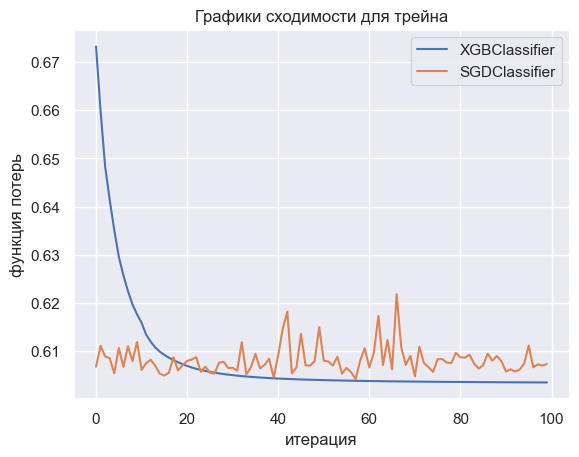

In [108]:
import matplotlib.pyplot as plt

plt.plot(xgd_loss_train)
plt.plot(sgd_loss_train)
plt.legend(['XGBClassifier', 'SGDClassifier'])
plt.title('Графики сходимости для трейна')
plt.xlabel('итерация')
plt.ylabel('функция потерь')
plt.show()

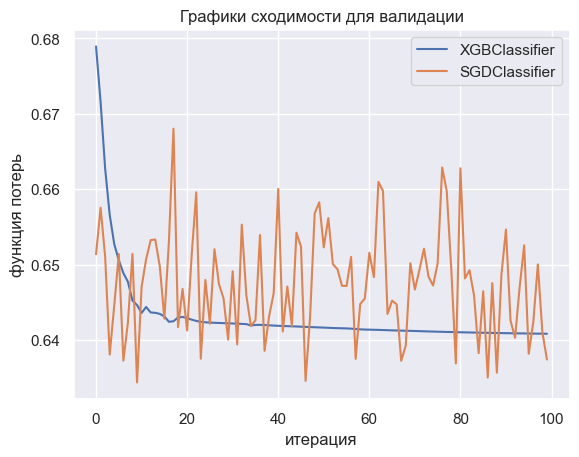

In [109]:
plt.plot(xgd_loss_val)
plt.plot(sgd_loss_val)
plt.legend(['XGBClassifier', 'SGDClassifier'])
plt.title('Графики сходимости для валидации')
plt.xlabel('итерация')
plt.ylabel('функция потерь')
plt.show()

<font color='#b962c4'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='#b962c4'>**Ответ:** 

<font color='#b962c4'>XGBClassifier сходится дольше, но стабильнее на обоих выборках.

<font color='#b962c4'>На трейне графики более стабильные и гладкие, чем на валидации.

<font color='#b962c4'>Время обучения SGDClassifier гораздо больше(но это из-за циклов).

### 2.2. Категории 2.0 (0.75 балла)

Пока что для простоты картины мы игнорировали категориальные признаки. <font color='#c4bf0a'>CatBoost</font> в частности предлагает один из самых эффективных и быстрых вариантов кодировки категорий, который мы попробуем повторить

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$


Добавьте в модель вот это:
- `cat_features: Iterable | None` — категориальные признаки для кодирования
- `_cat_fit(self, X: np.array, y: np.ndarray)` — внутренний метод для построения счетчиков
- `_cat_transform(self, X: np.ndarray)` — внутренний метод для применения счетчиков

Лмбо сделайте энкодер отдельным классом с аналогичными методами `fit` и `transform`, это даже лучше. Его нужно прогнать всего раз для каждой из выборок

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center">-</td>
<td align="center"><code>cat_features</code></td>
</tr>
</table>

</div>

Закодируйте переменные, которые вы хотите считать категориальными, с помощью счётчиков (готовые реализации брать нельзя) и покажите эффект. Помните, что все должно быть векторизовано и красиво

In [110]:
# вернем occupation туда, где ему самое место, но это не единственная кат фича!

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=1337
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1337
)

X_train.shape, X_valid.shape, X_test.shape

((8000, 12), (1000, 12), (1000, 12))

In [111]:
print(list(X.columns).index('occupation'))  

11


In [112]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_roc_auc',
    n_estimators=100,
    cat_features=[11],
    bootstrap_type=None
)

boosting._cat_fit(X_train, y_train)
X_train_coded = boosting._cat_transform(X_train)

In [113]:
X_train_coded.shape

(8000, 12)

***Массив закодированнных категориальных признаков***

In [114]:
X_train_coded[:, 11]

array([np.float64(-0.09019607843137255), np.float64(0.17204301075268819),
       np.float64(-0.01870503597122302), ...,
       np.float64(-0.2644757433489828), np.float64(-0.19642857142857142),
       np.float64(0.5675675675675675)], dtype=object)

### Бонус. Категории 3.0 (0.5 балла)

Увы, закодированные признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем утечку целевой переменной в признаки, но с этим можно жить, в частности это одна из главных фишек <font color='#c4bf0a'>CatBoost</font>, была. Почитайте [статью](https://arxiv.org/pdf/1706.09516), она интересная

Реализуйте подсчет счетчиков так, чтобы кодировка категории была только по объектам. расположенным выше в датасете (например, если у нас выборка отсортирована по времени)

Методы добавлять не нужно, разве что очень хочется, предполагается, что это дефолтное поведение бустинга, на самом деле, если не нужен `OneHotEncoder `

In [59]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.3. Бутстрап (0.75 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

> Идея, которая за этим стоит проста - бустинги переобучаются, как черти. Бутстрап же может сделать процесс куда более робастным и быть одним из способов регуляризации, а заодно уменьшить время обучения, в случае бутстрапа Бернулли

Вам нужно реализовать параметры:
- `subsample: float = 1.0` — доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float = 1.0` — температура для генерации весов. Соответствует бутстрапу типа `Bayesian`. Каждому объекту присваивается вес $w$, который получается из температуры $t$, после чего объект, в количестве $w$, попадает в выборку. \
$w = (-\log(X))^t$, где $X \sim {U[0, 1]}$ \
Таким образом можно сделать симуляцию повторений, обобщив на непрерывный случай. Обычный бутстрап не умеет сэмплировать дробное число объектов, но можно сделать примерно то же самое, если размножить объект $w$ раз, либо присвоить вес. Подумайте, как это корректно реализовать в бустинге
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>subsample</code>, -</td>
<td align="center"><code>subsample</code>, <code>bagging</code></td>
<td align="center"><code>subsample</code>, <code>bootstrap_type</code></td>
</tr>
</table>

</div>

<font color='#b962c4'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='#b962c4'>**Ответ:** смещение должно увеличиться, так как мы не переобучаемся под конкретную выборку, а выборка каждый раз разная; разброс уменьшается; также выбросы попадают не во все модели, поэтому ансамбль устойчив к выбросам.

***Вариант для Bayesian бутстреп***

  0%|          | 0/200 [00:00<?, ?it/s]

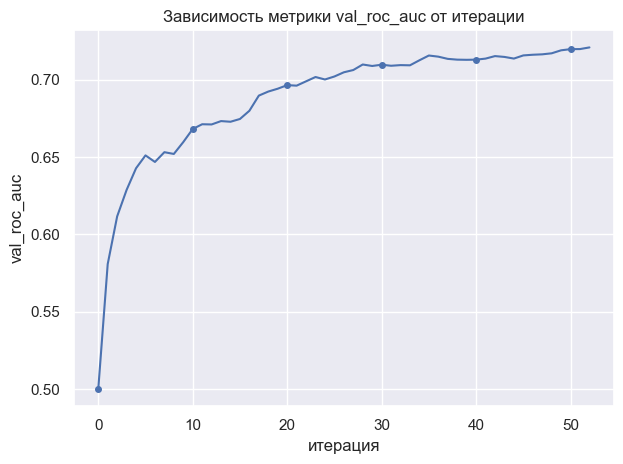

In [122]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_roc_auc',
    n_estimators=200,
    cat_features=[11],
    subsample = 0.8,
    bagging_temperature = 0.8,
    bootstrap_type = 'Bayesian'
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', m=10, t=10)

***Вариант для Bernoulli бутстреп***

  0%|          | 0/250 [00:00<?, ?it/s]

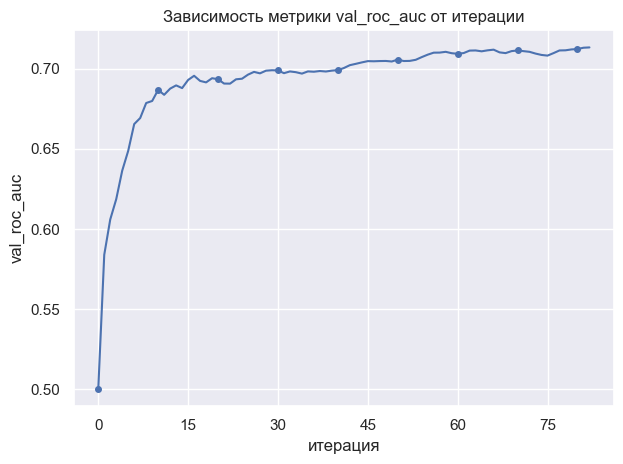

In [123]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_roc_auc',
    n_estimators=250,
    cat_features=[11],
    subsample = 0.8,
    bootstrap_type = 'Bernoulli',
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', m=10 ,t=15)

Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать параметр `rsm`

В библиотеках это реализовано так:

<div align="center">

| <font color="#2f82d4">XGBoost</font> | <font color="#41a657">LightGBM</font> | <font color='#d1cd3b'>CatBoost</font> |
| :---: | :---: | :---: |
| `colsample_bytree`| `colsample_bytree`| `rsm`|

</div>

Нужно добавить параметр:
- `rsm: float = 1.0` — доля признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли

***После добавления rsm***

  0%|          | 0/300 [00:00<?, ?it/s]

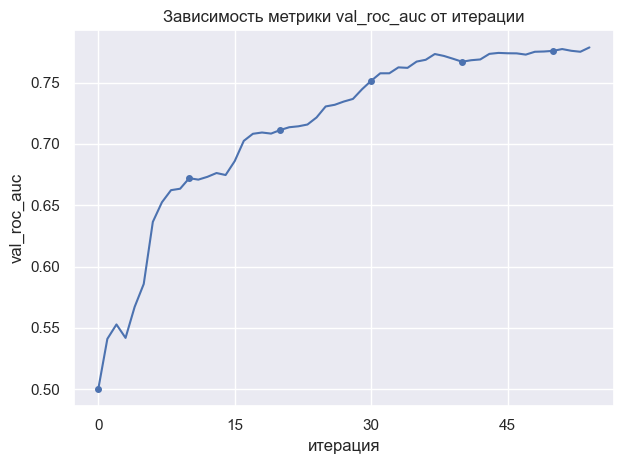

In [124]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_roc_auc',
    n_estimators=300,
    cat_features=[11],
    subsample = 0.8,
    bagging_temperature = 0.8,
    bootstrap_type = 'Bayesian',
    rsm=0.7
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', m=10, t=15)

### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='#53c96c'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

> Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобьем градиенты на 2 группы. Объекты с большими (по модулю) градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

Параметры, которые нужно сделать:

- `goss: bool = False` — GOSS бустинг или нет
- `goss_k: float = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float = 0.3` — параметры сэмплинга Бернулли для маленьких градиентов из пункта 2.3

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center"><code>bagging='goss'</code></td>
<td align="center"><code>bootstrap_type='MVS'</code></td>
</tr>
</table>

</div>

Сделайте и посмотрите

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.4. Бинаризация (0.5 балла)

Вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет.

> Зачем это? Да все очень просто! Квантизованные данные весят гораздо меньше, значений в них куда как меньше, а значит, наше обучение пойдет гораздо быстрее, к тому же все снова станет устойчивее. Беда лишь в новых данных, которые могут оказаться вне бина, но великие силы избавили нас от этих проблем в нашем датасете. Фактически мотивация вновь та же, что у бутстрапа

Нужно добавить параметры:
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

Либо сделать квантизатор отдельным классом, где в `fit` запоминаются пороги, а в `transform` преобразуются фичи

Рассмотрим варианта `quantization_type`:

- `'uniform'` — значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- `'quantile'` — тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>tree_method</code></td>
<td align="center"><code>max_bin</code></td>
<td align="center"><code>quantize(...)</code></td>
</tr>
</table>

</div>

Разницу между ними вы можете увидеть на картинке, где квантизуется гауссиана

<img src="https://i.postimg.cc/gJ2SJgpN/image-2025-11-29-201502496.png">

Реализуйте их, примените их к числовым признакам, и покажите, что все работает четко

***Бинаризация uniform***

  0%|          | 0/250 [00:00<?, ?it/s]

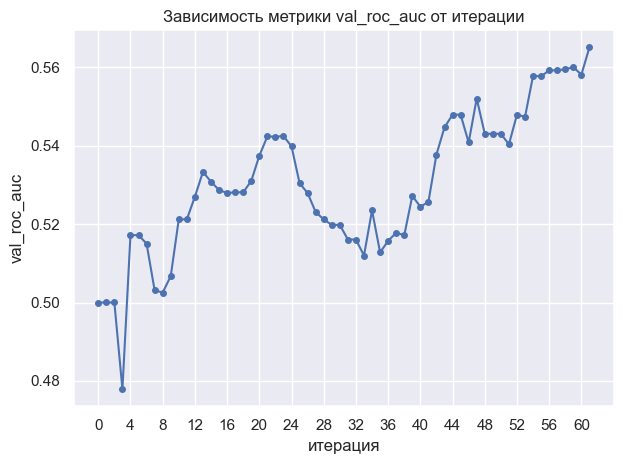

In [144]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=20,
    eval_metric='val_roc_auc',
    n_estimators=250,
    cat_features=[11],
    subsample = 0.8,
    bagging_temperature = 0.8,
    bootstrap_type = 'Bernoulli',
    quantization_type='uniform',
    nbins=150
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', m=1, t=4)

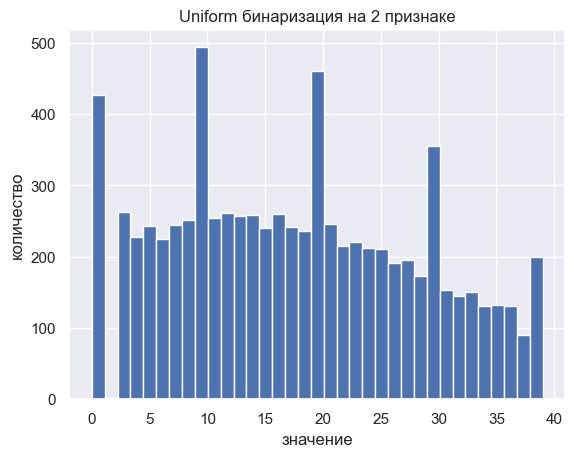

In [147]:
plt.hist(boosting.preprocessor.transform(X_train)[:, 1], bins=35)
plt.title('Uniform бинаризация на 2 признаке')
plt.xlabel('значение')
plt.ylabel('количество')
plt.show()

***Бинаризация quantile***

  0%|          | 0/100 [00:00<?, ?it/s]

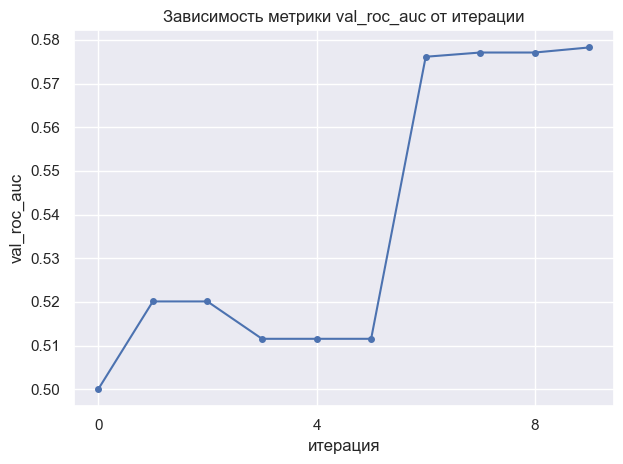

In [152]:
boosting = Boosting(
    verbose=True,
    random_state=69,
    early_stopping_rounds=40,
    eval_metric='val_roc_auc',
    n_estimators=100,
    cat_features=[11],
    subsample = 0.8,
    bagging_temperature = 0.8,
    bootstrap_type = 'Bayesian',
    quantization_type='quantile',
    nbins=100
)

boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
boosting.plot_history(keys='val_roc_auc', m=1, t=4)

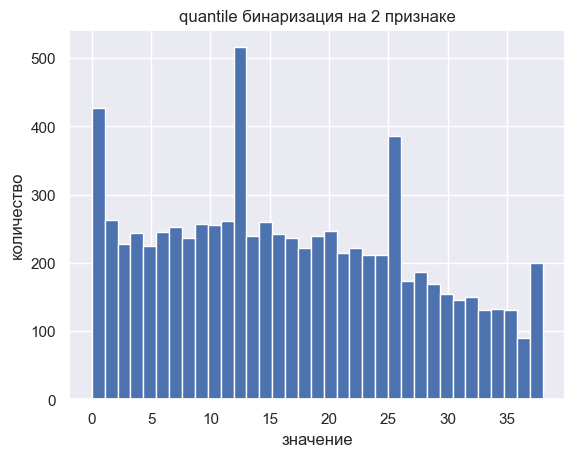

In [153]:
plt.hist(boosting.preprocessor.transform(X_train)[:, 1], bins=35)
plt.title('quantile бинаризация на 2 признаке')
plt.xlabel('значение')
plt.ylabel('количество')
plt.show()

<font color='#b962c4'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='#b962c4'>**Ответ**: квантизация растянет диапазон значений, если есть выбросы (uniform), в случае quantile применение устойчивое, выбросы уйдут в крайние бины. Квантизация не работает с нанами. Их надо обработать до применения квантизации.

<font color='#b962c4'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='#b962c4'>**Ответ**: можно, если нанов немного. Не стоит заполнять выбросами, лучше заполнить медианным значением.

### Бонус. Квантизация (0.5 балла)

В современных имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, в каких-то значения повторяются, в каких-то нет, либо от того, что целевая переменная от бинов зависит опосредованно, да и пороги берутся с потолка

Есть два необычных, но крайне интересных подхода:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='#c4bf0a'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы суммарная побиновая энтропия объектов ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Это, правда, предполагает, что значения числовых фичей могут повторяться, и так и есть в части наших колонок
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета через максимизацию InfoGain \
NB: В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лишь закодированную по формуле часть

Оба метода на самом деле похожи, поэтому выбирайте на свой вкус. Оба пытаются подобрать пороги при помощи некоторого алгоритма, который тоже работает с энтропией или InfoGain, возможно, вы его даже знаете, осталось правильно его применить. В библиотеках способы реализации чуть отличаются, и предлагаемый способ не единственный. Если есть желание - экспериментируйте!

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center">-</td>
<td align="center"><code>feature_border_type="Piecewise"</code></td>
</tr>
</table>

</div>

Добавьте одну из опций, `'min_entropy'` или `'piecewise'`, для `quantization_type` и покажите, что оно работает

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.5. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и взвешенно усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor` и знанием о гаммах), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>model.get_score()</code></td>
<td align="center"><code>lightgbm.importance()</code></td>
<td align="center"><code>model.get_feature_importance()</code></td>
</tr>
</table>

</div>

Покажите, какие признаки оказались самыми важными

In [77]:
for i, j in zip(boosting.feature_importances_(), X.columns):
    print(f'{j}: {i}')

region: 0.10060208098850991
age: 0.12851068032147533
year: 0.06932171698934533
race: 0.040602349133637854
sch: 0.06476340429359348
empstat: 0.0
occ: 0.06040510160401295
ind: 0.09021474647079883
annhrs: 0.06899537806932962
hrwage: 0.08343695178906077
incwage: 0.08216545120254164
occupation: 0.2109821391376943


***Наибольшая значимость у occupation 21% и age 13%***

### Бонус. DART (1 балл)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению, если проводить аналогию с весами. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

> В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

Параметры, которые нужно добавить:

- `dart: bool = False` — DART бустинг или нет
- `dropout_rate: float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>XGBClassifier(booster="dart")</code></td>
<td align="center"><code>LGBMClassifier(boosting_type="dart")</code></td>
<td align="center">-</td>
</tr>
</table>

</div>

Попробуйте обучить DART на наших данных. Статью читать настоятельно рекомендуется, метод не самый простой

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

------

## Задание 3. Около бустинга (2.5 балла | 0.5 бонус)

Теперь давайте проанализируем, как же правильно готовить бустинги. Нас интересует: как тюнить бустинги, какие они вообще бывают и как их интерпретировать. Посмотрим на все это по порядку

### 3.1. Optuna наносит ответный удар (0.5 балла)

Если вы помните, у нас уже было знакомство с библиотекой `optuna` для подбора гиперпараметров. Вспомним, как это делается и подумаем, как это можно делать еще лучше

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Покажите, какие из них дали наибольший прирост (для этого придется почитать документацию оптуны)

In [160]:
def objective(study, model="custom_boosting"):
    # Обязательные параметры
    boosting_params = {
        'n_estimators': study.suggest_int('n_estimators', 10, 300),
        'learning_rate': study.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'early_stopping_rounds': 20,
        'random_state': 69,
        'verbose': True,
        'cat_features': [11]
    }
    
    # Параметры дерева
    tree_params = {
        'max_depth': study.suggest_int('max_depth', 3, 10)
    }
    
    # Условные параметры
    conditional_params = {}
    bootstrap_type = study.suggest_categorical('bootstrap_type', ['Bernoulli', 'Bayesian', None])
    conditional_params['bootstrap_type'] = bootstrap_type
    if bootstrap_type in ['Bernoulli', 'Bayesian']:
        conditional_params['subsample'] = study.suggest_float('subsample', 0.5, 1.0)
    if bootstrap_type == 'Bayesian':
        conditional_params['bagging_temperature'] = study.suggest_float('bagging_temperature', 0.0, 1.0)
    conditional_params['rsm'] = 1.0
    conditional_params['quantization_type'] = None
    conditional_params['eval_metric'] = 'val_roc_auc'
    
    model = Boosting(
        base_model_params=tree_params,
        **boosting_params,
        **conditional_params
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    score = model.history['val_roc_auc'][-1]
    
    return 1 - score

In [161]:
import optuna

# Создаем study
study = optuna.create_study(
    direction='minimize',
    study_name='boosting_learning',
    sampler=optuna.samplers.TPESampler(seed=69),
)

# Запускаем оптимизацию
study.optimize(objective, n_trials=20)

[I 2025-12-12 22:46:31,368] A new study created in memory with name: boosting_learning


  0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-12-12 22:47:08,637] Trial 0 finished with value: 0.2582930331721326 and parameters: {'n_estimators': 96, 'learning_rate': 0.15670798246488907, 'max_depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5524885418425545}. Best is trial 0 with value: 0.2582930331721326.


  0%|          | 0/27 [00:00<?, ?it/s]

[I 2025-12-12 22:47:13,440] Trial 1 finished with value: 0.29034916139664557 and parameters: {'n_estimators': 27, 'learning_rate': 0.09874940471509769, 'max_depth': 8, 'bootstrap_type': 'Bayesian', 'subsample': 0.6588402983099821, 'bagging_temperature': 0.7410232771836268}. Best is trial 0 with value: 0.2582930331721326.


  0%|          | 0/105 [00:00<?, ?it/s]

[I 2025-12-12 22:47:59,300] Trial 2 finished with value: 0.30000120000480013 and parameters: {'n_estimators': 105, 'learning_rate': 0.04948366847334379, 'max_depth': 4, 'bootstrap_type': None}. Best is trial 0 with value: 0.2582930331721326.


  0%|          | 0/95 [00:00<?, ?it/s]

[I 2025-12-12 22:48:28,026] Trial 3 finished with value: 0.27516510066040256 and parameters: {'n_estimators': 95, 'learning_rate': 0.025652274464092902, 'max_depth': 8, 'bootstrap_type': 'Bayesian', 'subsample': 0.6938331426328919, 'bagging_temperature': 0.33544620663849345}. Best is trial 0 with value: 0.2582930331721326.


  0%|          | 0/159 [00:00<?, ?it/s]

[I 2025-12-12 22:50:10,022] Trial 4 finished with value: 0.23752095008380036 and parameters: {'n_estimators': 159, 'learning_rate': 0.2876997855162363, 'max_depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.853612863184695}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/130 [00:00<?, ?it/s]

[I 2025-12-12 22:50:39,391] Trial 5 finished with value: 0.30125920503682013 and parameters: {'n_estimators': 130, 'learning_rate': 0.04716459228597066, 'max_depth': 5, 'bootstrap_type': None}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/66 [00:00<?, ?it/s]

[I 2025-12-12 22:50:59,898] Trial 6 finished with value: 0.3106432425729704 and parameters: {'n_estimators': 66, 'learning_rate': 0.048629910321233275, 'max_depth': 4, 'bootstrap_type': None}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/84 [00:00<?, ?it/s]

[I 2025-12-12 22:51:32,792] Trial 7 finished with value: 0.2827811311245245 and parameters: {'n_estimators': 84, 'learning_rate': 0.0126611591181735, 'max_depth': 10, 'bootstrap_type': 'Bayesian', 'subsample': 0.6955251089441661, 'bagging_temperature': 0.37876973050352947}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/199 [00:00<?, ?it/s]

[I 2025-12-12 22:54:12,297] Trial 8 finished with value: 0.25637702550810193 and parameters: {'n_estimators': 199, 'learning_rate': 0.18400387576101693, 'max_depth': 6, 'bootstrap_type': None}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/46 [00:00<?, ?it/s]

[I 2025-12-12 22:54:24,226] Trial 9 finished with value: 0.28182512730050924 and parameters: {'n_estimators': 46, 'learning_rate': 0.24943971202975534, 'max_depth': 10, 'bootstrap_type': 'Bayesian', 'subsample': 0.9890877520019175, 'bagging_temperature': 0.28127815478903406}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/293 [00:00<?, ?it/s]

[I 2025-12-12 22:56:19,184] Trial 10 finished with value: 0.26063304253217 and parameters: {'n_estimators': 293, 'learning_rate': 0.10381236569852709, 'max_depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9038736083309444}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/209 [00:00<?, ?it/s]

[I 2025-12-12 22:58:23,623] Trial 11 finished with value: 0.23875695502782013 and parameters: {'n_estimators': 209, 'learning_rate': 0.26169486076390425, 'max_depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8605181472996127}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/195 [00:00<?, ?it/s]

[I 2025-12-12 22:59:38,183] Trial 12 finished with value: 0.25166500666002656 and parameters: {'n_estimators': 195, 'learning_rate': 0.2631392977987941, 'max_depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8471918344016769}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/206 [00:00<?, ?it/s]

[I 2025-12-12 23:02:16,035] Trial 13 finished with value: 0.2430649722598892 and parameters: {'n_estimators': 206, 'learning_rate': 0.11128712870680708, 'max_depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.831790251987371}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/256 [00:00<?, ?it/s]

[I 2025-12-12 23:03:54,620] Trial 14 finished with value: 0.2530490121960488 and parameters: {'n_estimators': 256, 'learning_rate': 0.27805088522149163, 'max_depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8100264062006454}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/159 [00:00<?, ?it/s]

[I 2025-12-12 23:05:27,677] Trial 15 finished with value: 0.25312101248404995 and parameters: {'n_estimators': 159, 'learning_rate': 0.1760991958712648, 'max_depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9499216191671895}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/242 [00:00<?, ?it/s]

[I 2025-12-12 23:05:38,435] Trial 16 finished with value: 0.2851331405325621 and parameters: {'n_estimators': 242, 'learning_rate': 0.08022358076653474, 'max_depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7710439476680755}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/167 [00:00<?, ?it/s]

[I 2025-12-12 23:05:52,684] Trial 17 finished with value: 0.26962107848431405 and parameters: {'n_estimators': 167, 'learning_rate': 0.029019241388261632, 'max_depth': 9, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8924051967406346}. Best is trial 4 with value: 0.23752095008380036.


  0%|          | 0/237 [00:00<?, ?it/s]

[I 2025-12-12 23:09:14,216] Trial 18 finished with value: 0.23425693702774808 and parameters: {'n_estimators': 237, 'learning_rate': 0.16105508255376239, 'max_depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7587450524963758}. Best is trial 18 with value: 0.23425693702774808.


  0%|          | 0/292 [00:00<?, ?it/s]

[I 2025-12-12 23:15:45,946] Trial 19 finished with value: 0.23658494633978533 and parameters: {'n_estimators': 292, 'learning_rate': 0.13555162123450776, 'max_depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5902750534447502}. Best is trial 18 with value: 0.23425693702774808.


AttributeError: 'Study' object has no attribute 'best_study'

***Часть кода без ошибки переписана ниже, не было времени перегнать, также есть код для определения значимости признаков, также не успела прогнать (написала с переобпределением переменной study не сохранлся***

In [162]:
# Выводим результаты для лучшей модели
trial = study.best_trial
for key, value in trial.params.items():
    print(f'{key}: {value}')

n_estimators: 237
learning_rate: 0.16105508255376239
max_depth: 5
bootstrap_type: Bernoulli
subsample: 0.7587450524963758


In [168]:
importances = optuna.importance.get_param_importances(study)
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения

1. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из [`optuna.pruners`](https://optuna.readthedocs.io/en/stable/reference/pruners.html), либо можно написать своё. Идея прунера — не обучать бустинг до конца, если по истории валидации видно, что другие бустинги на этом этапе статистически лучше, для этого мы и делали `partial_fit`.
2. Если мы ценим наше время, можно внести в процесс оптимизации немного определенности и, например, сказать, что если мы достигли определенного качества, то этого нам уже хватит с головой. Объект со смешным названием [`optuna.terminator`](https://optuna.readthedocs.io/en/stable/reference/terminator.html) позволяет нам остановить оптимизацию по достижении некоторого трешхолда по какому-либо параметру, который мы сами придумали, например, качестве на тесте

Чего от вас хочет автор?
1. Добавьте другие параметры, которые вы реализовали во время выполнения дз, в `objective`, они хорошие и могут вам помочь
1. Попробуйте ускорить оптимизацию при помощи своего или библиотечного прунера и/или терминатора. Если ускорения нет, скорее всего, вы вставили его неправильно
2. Побейте трешхолд ROC-AUC в 0.84 на тесте, если в предыдущем пункте этого сделать не удалось. Помните, что у вас есть целая история обучения, и лучшим трайалом может быть что-то из топ-10, а не только из топ-1

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 3.3. Готовые реализации (0.5 балла)

Библиотек для бустингов существует много, но активно используются лишь три. Вам предстоит попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='#2f82d4'>XGBoost</font>, <font color='#53c96c'>LightGBM</font> или <font color='#c4bf0a'>CatBoost</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения
- оптимальному набору гиперпараметров

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

<font color='#b962c4'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='#b962c4'>**Ответ**: ... </font>

### Бонус. Еще пара красивых слов (0.5 балла)

Разумеется, мы рассмотрели далеко не все классные фишки, которые есть в библиотеках. Ниже есть набор заданий, выберите одно, которое кажется вам наиболее интересным

- <font color='#2f82d4'>XGBoost</font> известен тем, что в нем впервые повилась регуляризация. Ручками ее написать сложно, но тут и не требуется. Добавьте обе регуляризации, что там есть, как параметры в оптуну и прогоните процесс оптимизации только на них. Оцените экспертно, насколько прямая регуляризация эффективна, по сравнению с регуляризацией деревьев
- <font color='#53c96c'>LightGBM</font> содержит в себе в том числе реализацию своего злейшего врага - случайный лес. Посмотрите, какие есть параметры у него, обучите и ответьте на <font color='#b962c4'>вопрос "кто победит: бустинг или лес? и почему?" </font>
- <font color='#c4bf0a'>CatBoost</font> славится множеством функций, кажется в этом ноутбуке, только про них и говорили. Славится он еще и кучей разных подходов к обучению деревьев, в частности он умеет мерджить несколько моделей в одно. Это не стекинг, и даже не беггинг, а что-то поинтереснее. Попробуйте разбить выборку на фолды и обучить по катбусту на каждом из них, а затем их склеить. Тюнить их не надо, он и так неплох, в этом его сила и мудрость. Оцените, насколько это круто по 10-балльной

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>alpha</code>, <code>lambda</code></td>
<td align="center"><code>boosting_type="rf"</code></td>
<td align="center"><code>sum_models</code>, <code>to_classifier</code></td>
</tr>
</table>

</div>

Посмотрите на выбранную вами фичу и покажите, как хорошо или плохо она работает

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но таки что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

Конечно же, бустинг великолепен, как он есть, но можно сделать его еще лучше, если его откалибровать

1. Посмотрите на то, как это делать из библиотеки `sklearn`. Обратите внимание, передаете вы в него обученную модель или нет, а также на чем вы калибруетесь. Иначе есть риск что-то поломать
2. Откалибруйте вашу реализацию бустинга. Для этого за вас к нему был замешан `ClassifierMixin`
3. Покажите, как изменилась мера откалиброванности, для этого есть \
$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$ \
$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$
4. Нарисуйте новую калибровочную кривую

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

<font color='#b962c4'>**Вопрос:** Как вы можете прокомментировать то, что получилось?</font>

<font color='#b962c4'>**Ответ**: ... </font>

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2026 года?

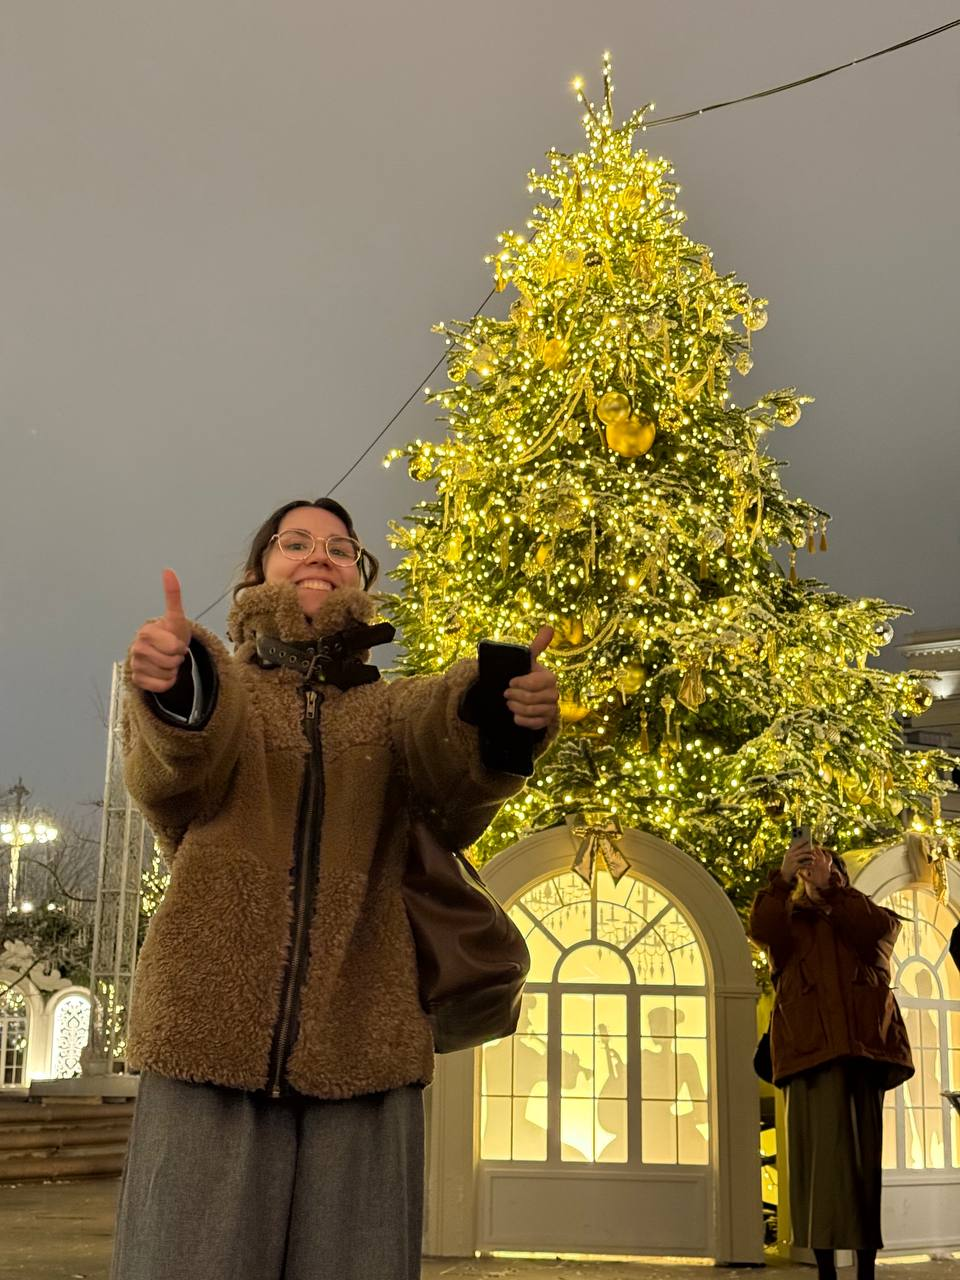

In [31]:
from IPython.display import Image, display
Image(filename='HNY.jpg', width=400, height=300)

От Нового года жду много впечатлений, знакомств и места в штате компании!

С наступающим Новым годом 🎄🎅🎁✨

Спасибо за классные пары!!!